In [1]:
import gzip

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from matplotlib import pyplot as plt

In [2]:
def read_geo_series_matrix(file_path):
    cols = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sampleId = [i.strip('"') for i in line.split()[1:]]
                cols["sampleId"] = sampleId
            elif line.startswith("!Sample_characteristics_ch1"):
                _ = line[28:].strip().strip('"').split('"\t"')
                category = _[0].split(": ")[0].replace(" ", "_")
                values = [i.split(": ")[1] for i in _]
                cols.update({category: values})
    
    return pd.DataFrame(cols)

In [3]:
meta = read_geo_series_matrix("../rawData/GSE49711_series_matrix.txt.gz")
meta.index = meta.sampleId
meta.shape

(498, 11)

In [4]:
meta = meta.loc[meta.class_label.isin(["0", "1"])]
meta.shape

(272, 11)

In [5]:
meta.Sex.replace({"M":1, "F":0}, inplace=True)
meta.replace({"N/A":np.nan}, inplace=True)

In [6]:
stage_dummy = pd.get_dummies(meta.inss_stage, prefix='inss_stage')
meta = pd.concat([meta, stage_dummy], axis=1)

In [7]:
meta.dropna(inplace=True)

In [8]:
meta_X = meta[["Sex", "age_at_diagnosis", "mycn_status", "high_risk", 
               "inss_stage_1", "inss_stage_2", "inss_stage_3", "inss_stage_4", "inss_stage_4S"
              ]]

In [9]:
meta_X = meta_X.astype("double")

In [12]:
X_train, X_test, y_train, y_test = train_test_split(meta_X, meta.class_label.astype("int"), test_size=0.4, random_state=1234)

In [23]:
scaler = StandardScaler()
age_at_diagnosis = scaler.fit_transform(np.array(X_train.age_at_diagnosis).reshape(-1, 1))

In [25]:
X_train.age_at_diagnosis = age_at_diagnosis

In [26]:
X_train

,Sex,age_at_diagnosis,mycn_status,high_risk,inss_stage_1,inss_stage_2,inss_stage_3,inss_stage_4,inss_stage_4S
sampleId,,,,,,,,,
SEQC_NB268,1.0,2.849900,1.0,1.0,0.0,0.0,0.0,1.0,0.0
SEQC_NB305,0.0,-0.664979,0.0,0.0,0.0,0.0,0.0,0.0,1.0
SEQC_NB198,0.0,-0.287794,1.0,1.0,0.0,0.0,1.0,0.0,0.0
SEQC_NB377,1.0,0.642776,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SEQC_NB216,1.0,-0.435548,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
SEQC_NB218,1.0,-0.668649,0.0,0.0,0.0,1.0,0.0,0.0,0.0
SEQC_NB244,1.0,-0.011560,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SEQC_NB328,0.0,0.755656,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [47]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=1234)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test.loc[:, X_train.columns])

In [48]:
accuracy = accuracy_score(y_test, y_pred)

In [49]:
accuracy

0.9537037037037037

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        78
           1       0.93      0.90      0.92        30

    accuracy                           0.95       108
   macro avg       0.95      0.94      0.94       108
weighted avg       0.95      0.95      0.95       108



In [34]:
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

In [38]:
# Print the feature ranking
print("Feature ranking:")
for f in range(9):
    print("%d. %s: feature %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. high_risk: feature 3 (0.362682)
2. inss_stage_4: feature 7 (0.219939)
3. age_at_diagnosis: feature 1 (0.209805)
4. mycn_status: feature 2 (0.073747)
5. inss_stage_1: feature 4 (0.046569)
6. inss_stage_3: feature 6 (0.031470)
7. inss_stage_2: feature 5 (0.023123)
8. Sex: feature 0 (0.020178)
9. inss_stage_4S: feature 8 (0.012488)


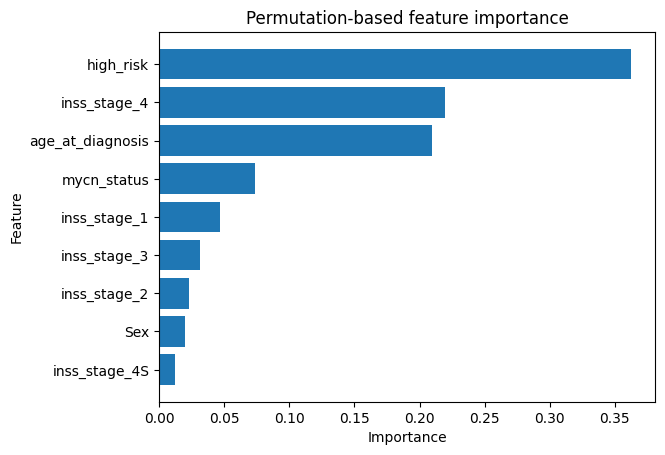

In [40]:
plt.barh(X_train.columns[indices][range(9)][::-1], importances[indices][range(9)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [42]:
pd.crosstab(y_pred, y_test)

class_label,0,1
row_0,,
0,76,3
1,2,27


In [41]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].class_label)

class_label,0,1
high_risk,,
0,78,5
1,0,25


In [43]:
import xgboost as xgb

In [50]:
clf = xgb.XGBClassifier(random_state=1234)


In [51]:
clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1234, ...)

In [52]:
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9537037037037037


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        78
           1       0.93      0.90      0.92        30

    accuracy                           0.95       108
   macro avg       0.95      0.94      0.94       108
weighted avg       0.95      0.95      0.95       108

